___

**project**: `gender classification`

**date**: `2021-11-30`

**decription**: `given a face image of a human being, classify the gender using artificial nueral nets.`

**main**: `computer vision(cv)`

**programmer**: `crispen gari`

**architecture**: `vgg16 (transfare learning)`


___

### Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import os
import numpy as np

### Mounting the Drive

Our image faces are stored in one folder `gender-classification` in this folder we have two subfolder for each class

1. male
2. female

> Note that we are loading these images from my google drive, so we need to mount the drive as follows:

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [19]:
base_path = "/content/drive/MyDrive/Computer Vision/gender-classification"

### Creating an Image Dataset

We are going to create an imeage dataset using the `flow_from_directory` method in keras image processing.


Our image directory looks as follows:

```
📁 gender-classification
    📁 male
      -image
      ...
    📁 female
      -image
      ...
```

So we are going to take `.15` fraction of the train whole dataset to belong to the `validation` set and the rest will belong to the `training` set.


### ImageDataGenerator

We are going to use the `ImageDataGenarator` class from `keras.preprocessing.image` to define our data generator and specify the faction of the validation sample.

In [22]:
data_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    data_format = "channels_last",
    dtype = tf.float32,
    validation_split = .15
)

### Creating datasets

We are then going to create the datasets. We will be having two sets, the train and validation. We are also going to use the `categorical` class mode so that our labels will be `one_hot` encoded vectors, In the model compilation we will use the `categorical_cross_entropy` loss function in this case.


> Note that, we can use the `binary` mode since this is a binary classification, but the difference is the same, we will get the same metrics either way.



We will be using the `data_gen.flow_from_directory` method to preprocess our images and labels from the directory.

In [23]:
train_ds = data_gen.flow_from_directory(
   base_path,
   target_size=(96, 96), # vgg16 imput size
   class_mode='categorical',
   batch_size=32,
   shuffle=True,
   seed=42,
   subset="training", # set 
  interpolation='nearest',
)


val_ds = data_gen.flow_from_directory(
   base_path,
   target_size=(96, 96), # vgg16 imput size
   class_mode='categorical',
   batch_size=32,
   shuffle=True,
   seed=42,
   subset="validation", #set 
  interpolation='nearest',
)

Found 9902 images belonging to 2 classes.
Found 1747 images belonging to 2 classes.


### Class names for our images


We are going to check the classes that we have in our dataset.

In [24]:
class_names = train_ds.class_indices
class_names

{'female': 0, 'male': 1}

In [25]:
classes = {v:k for k, v in class_names.items()}
classes

{0: 'female', 1: 'male'}

### Visualizing some examples

We are going to create a helper function that will visualize people's faces and tell us which label the face belongs to.

👩 👨

In [30]:
def plot_images(images_and_classes, labels, cols=5):
  rows = 3
  fig = plt.figure()
  fig.set_size_inches(cols * 2, rows * 2)
  labels = np.argmax(labels, axis=1)
  for i, (image, label) in enumerate(zip(images_and_classes, labels)):
      plt.subplot(rows, cols, i + 1)
      plt.axis('off')
      plt.imshow(image, cmap="gray")
      plt.title(classes[label], 
                color ='g', 
                 fontsize=16 )


In [27]:
for batch in train_ds:
  break

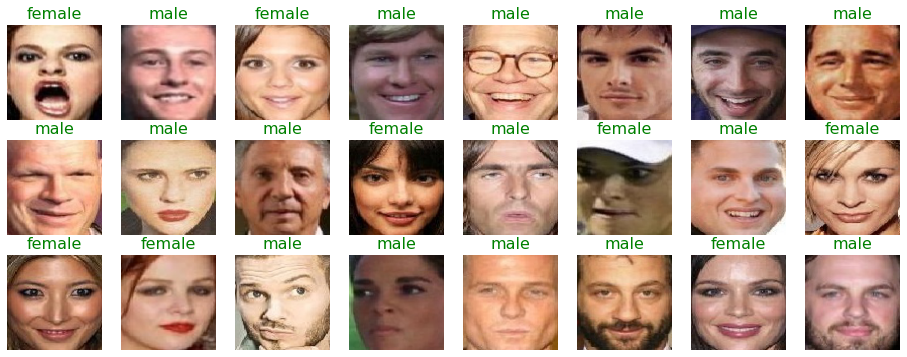

In [31]:
plot_images(batch[0][:24], batch[1][:24], cols=8)

### VGG16 model

We are going to download and load our vgg16 model from `keras.applications` as follows:

In [32]:
vgg = keras.applications.VGG16(input_shape=(96, 96, 3), weights='imagenet', include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

VGG16 models comes with `~14M` trainable parameters, but in our case we are going to freeze the trainable parameters of the vgg16 model by looping through all the layers and set `trainable` to `False` 

In [34]:
for layer in vgg.layers:
  layer.trainable = False

In [35]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

### Fine tunning `VGG16`

We need to add the clasification layer to our vgg16 model. What we will do is to.

1. flatten the layers
2. add an extra dense layer 
3. add a batch normalization layer before the output layer
4. finally adding the classification layer wich suite `2` classes.


We are going to use the `Sequential` api from keras to recreate our model as follows:

In [36]:
model = keras.Sequential(name="gender_classification")

# add vgg-layers
for layer in vgg.layers:
    model.add(layer)
    
model.add(keras.layers.Flatten(name="flatten_layer"))
model.add(keras.layers.Dense(512, activation="relu", name="fc_0"))
model.add(keras.layers.BatchNormalization(name="bn_layer"))
model.add(keras.layers.Dense(2, activation="softmax", name="output_layer"))

model.summary()

Model: "gender_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 24, 24, 2

Now we have `~2M` trainable parameters in our model and we can now compile it.

For the loss function we are going to use the `CategoricalCrossentropy` loss with `from_logits` as `False` because we have include `softmax` activation function in our output layer.


For the `metrics` we are going to add `accuracy`.


For the optimizer we are going to use `adam` with default parameters.


In [37]:
model.compile(
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer = 'adam',
    metrics=["acc"]
)

### Callbacks

We are going to have two callbacks during training 

1. ReduceLROnPlateau
2. EarlyStopping

In [38]:
lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0, mode='auto'
)

Now we can train our model, but first we will define some hyper parameters....

In [39]:
VERBOSE = 1
BATCH_SIZE = 64
VALIDATION_BATCH_SIZE = 32
EPOCHS = 10
CALL_BACKS = [lr_reduction, early_stopping]

In [42]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    verbose =VERBOSE,
    batch_size =BATCH_SIZE,
    epochs =EPOCHS,
    shuffle = True,
    callbacks=CALL_BACKS
)

Epoch 1/10
310/310 [==============================] - 8060s 26s/step - loss: 0.2750 - acc: 0.8957 - val_loss: 0.1956 - val_acc: 0.9170 - lr: 0.0010
Epoch 2/10
310/310 [==============================] - 27s 86ms/step - loss: 0.1867 - acc: 0.9284 - val_loss: 0.2004 - val_acc: 0.9244 - lr: 0.0010
Epoch 3/10
310/310 [==============================] - 26s 85ms/step - loss: 0.1649 - acc: 0.9350 - val_loss: 0.2234 - val_acc: 0.9124 - lr: 0.0010
Epoch 4/10
310/310 [==============================] - 27s 85ms/step - loss: 0.1493 - acc: 0.9433 - val_loss: 0.2150 - val_acc: 0.9262 - lr: 0.0010
Epoch 5/10
310/310 [==============================] - 27s 86ms/step - loss: 0.1417 - acc: 0.9457 - val_loss: 0.2211 - val_acc: 0.9239 - lr: 0.0010
Epoch 6/10
310/310 [==============================] - 27s 86ms/step - loss: 0.1273 - acc: 0.9504 - val_loss: 0.2593 - val_acc: 0.9159 - lr: 0.0010


### Visualizing the model training history

We are going to visualize the loss and accuracy from the `history` object

In [44]:
import pandas as pd

In [49]:
df = pd.DataFrame(history.history)
epochs = np.arange(1, 7)

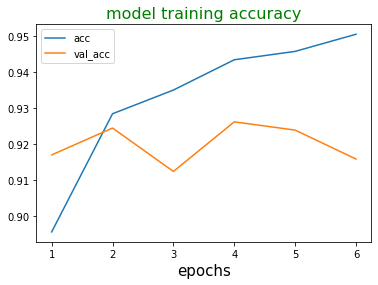

In [50]:
plt.plot(epochs,df["acc"], label="acc")
plt.plot(epochs,df["val_acc"], label="val_acc")
plt.title("model training accuracy", color="green", fontsize=16)
plt.legend()
plt.xlabel("epochs", fontsize=15)
plt.show()

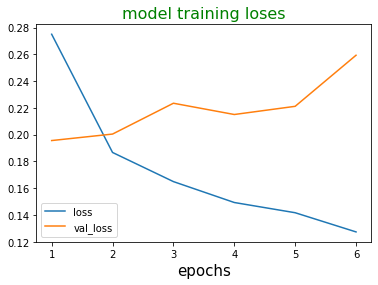

In [51]:
plt.plot(epochs,df["loss"], label="loss")
plt.plot(epochs,df["val_loss"], label="val_loss")
plt.title("model training loses", color="green", fontsize=16)
plt.legend()
plt.xlabel("epochs", fontsize=15)
plt.show()

### Evaluating the model

In [52]:
model.evaluate(val_ds, verbose=1, use_multiprocessing=True, batch_size=64)

55/55 [==============================] - 5s 82ms/step - loss: 0.2593 - acc: 0.9159


[0.2592849135398865, 0.9158557653427124]

### Model inference

Making predictions using our model.


We are going to make some predictions using our model and visualize them as well as how good the model performs by make use of the `confusion_matrix`.

In [53]:
for data in val_ds:
  break

In [54]:
predictions = np.argmax(model(data[0]).numpy(), axis=1).astype("int32")
y_true = np.argmax(data[1], axis=1).astype('int32')

plotting the predictions...

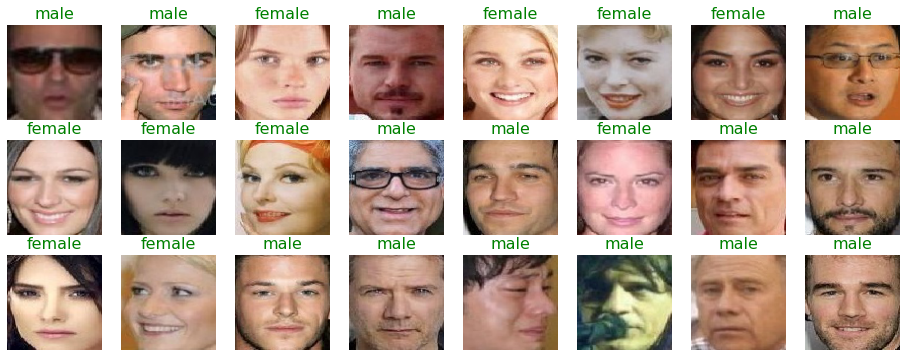

In [55]:
def plot_predictions_images(images_and_classes, 
                            labels_true, labels_pred, 
                            cols=5):
    rows = 3
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true.astype("int32"), labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image, cmap="gray")
        plt.title(classes[label_pred], color ='g' if label_true == label_pred else 'r', fontsize=16 )

plot_predictions_images(data[0][:24], y_true[:24], predictions[:24], cols=8)
                        

### The confusion matrix

The confusion matrix for the first batch in the data.

In [56]:
from sklearn.metrics import confusion_matrix
import itertools

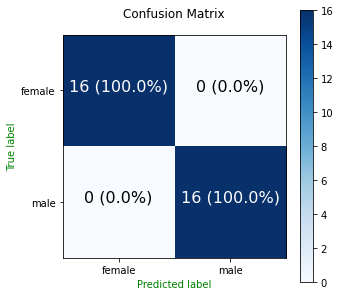

In [59]:
def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(5, 5), text_size=16): 
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
    n_classes = cm.shape[0]
  
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) 
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels,
         yticklabels=labels,
          )
    ax.yaxis.label.set_color('green')
    ax.xaxis.label.set_color('green')

    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    threshold = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)
        
plot_confusion_matrix(y_true, predictions, list(class_names.keys()))


### Classification report.


In [64]:
from sklearn.metrics import classification_report

In [70]:
cr = classification_report(y_true, predictions, output_dict=False, labels=y_true, target_names =[classes.get(i) for i in y_true])

In [73]:
print(cr)

              precision    recall  f1-score   support

        male       1.00      1.00      1.00        16
        male       1.00      1.00      1.00        16
      female       1.00      1.00      1.00        16
        male       1.00      1.00      1.00        16
      female       1.00      1.00      1.00        16
      female       1.00      1.00      1.00        16
      female       1.00      1.00      1.00        16
        male       1.00      1.00      1.00        16
      female       1.00      1.00      1.00        16
      female       1.00      1.00      1.00        16
      female       1.00      1.00      1.00        16
        male       1.00      1.00      1.00        16
        male       1.00      1.00      1.00        16
      female       1.00      1.00      1.00        16
        male       1.00      1.00      1.00        16
        male       1.00      1.00      1.00        16
      female       1.00      1.00      1.00        16
      female       1.00    

### Saving the model.

For the model saving guide from tensorflow you can read the docs [here](https://www.tensorflow.org/guide/keras/save_and_serialize). In our case we are going to save the model using the `H5` format as follows.


In [60]:
MODEL_NAME = "gender-classification.h5"

In [61]:
model.save(MODEL_NAME)
print("saved!")

saved!


### Downloading the model

We are going to download our model so that we can use it later on.

In [63]:
from google.colab import files

files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Loading the model

For that we are going to use the `keras.models.load_model` function>

In [62]:
loaded_model = keras.models.load_model(MODEL_NAME)

### ``make_prediction`` function

We are going to create a function called `make_prediction` that will make predictions given an image and returns us a good looking response.


In [90]:

def make_prediction(model, image):
  preds = model(np.array([image]))
  predictions = tf.squeeze(preds).numpy()
  prediction = np.argmax(predictions).astype("int32")
  preds_list = [{
      "label": i,
      "class": classes[i],
      "probability": np.round(pred, 2)
  } for i, pred in enumerate(predictions)]
  return {
      "label": prediction,
      "class": classes[prediction],
      "probability": np.round(predictions[prediction], 2),
      "predictions":preds_list
  }

make_prediction(loaded_model, data[0][0])

{'class': 'male',
 'label': 1,
 'predictions': [{'class': 'female', 'label': 0, 'probability': 0.0},
  {'class': 'male', 'label': 1, 'probability': 1.0}],
 'probability': 1.0}

In [92]:
data[1][0]

array([0., 1.], dtype=float32)

Now we have our `make_prediction` function that will make predictions based and returns us a well formated version of predictions.